In [2]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform, OrderedTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
from numpyro.diagnostics import effective_sample_size, print_summary
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
from jax.tree_util import tree_flatten, tree_map
from jax.scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import ete3


/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
# Simulate robot coffee shop data

In [3]:
a = 3.5 # average morning wait time
b = -1 # average difference between morning and afternoon wait time
sigma_a = 1 # std deviation in intercepts
sigma_b = 0.5 # std deviation in slopes
rho = -0.7 # correlation between intercets an slopes

mu = jnp.array([a, b])
sigma = jnp.array([ [sigma_a**2, sigma_a*sigma_b*rho],
                    [sigma_b*sigma_a*rho, sigma_b**2]])


In [4]:
sigma

DeviceArray([[ 1.  , -0.35],
             [-0.35,  0.25]], dtype=float32)

In [5]:
z = dist.MultivariateNormal(loc=mu, covariance_matrix=sigma).sample(random.PRNGKey(42), (20,1)).squeeze()
z

DeviceArray([[ 3.5573514 , -0.8938962 ],
             [ 3.461887  , -0.73139524],
             [ 3.9676046 , -1.2127522 ],
             [ 4.1943088 , -0.9899602 ],
             [ 3.0463588 , -0.7670051 ],
             [ 4.6753964 , -1.3571179 ],
             [ 5.344874  , -1.6519308 ],
             [ 4.0940065 , -0.58377767],
             [ 3.6405396 , -1.637854  ],
             [ 3.4600222 , -0.6870779 ],
             [ 4.695021  , -1.3464761 ],
             [ 1.5608462 , -0.72622883],
             [ 4.8558893 , -0.65045   ],
             [ 3.5576532 , -0.9834193 ],
             [ 4.8961353 , -1.6314702 ],
             [ 4.8211484 , -2.0196486 ],
             [ 1.9248444 , -0.39236492],
             [ 4.206654  , -1.0523813 ],
             [ 3.1807048 , -0.9944424 ],
             [ 4.6124325 , -1.5448456 ]], dtype=float32)

In [6]:
z.mean(axis=0)

DeviceArray([ 3.8876839, -1.0927247], dtype=float32)

In [7]:
z.std(axis=0)

DeviceArray([0.9515591 , 0.42815953], dtype=float32)

In [8]:
jnp.cov(z,rowvar=False)

DeviceArray([[ 0.95312077, -0.2769245 ],
             [-0.2769245 ,  0.19296905]], dtype=float32)

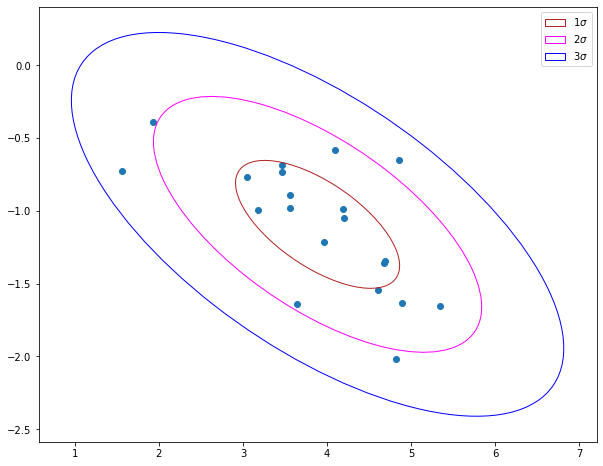

In [9]:
from confidence_ellipse import confidence_ellipse
fig, ax = plt.subplots(figsize=(10,8))
a = z[:,0]
b = z[:,1]
ax.scatter(a, b)
confidence_ellipse(a, b, ax, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(a, b, ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia')
confidence_ellipse(a, b, ax, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue')               
ax.legend()

In [10]:
n_visits = 10
prop_in_afternoon = 0.5
n_cafes = 20

cafe_id = jnp.repeat(jnp.arange(n_cafes),n_visits)
is_afternoon = jnp.tile(jnp.repeat(jnp.array([0,1]), (int(n_visits*prop_in_afternoon))),n_cafes)
mu = a[cafe_id] + b[cafe_id]*is_afternoon
wait = dist.Normal(mu, 0.5).sample(random.PRNGKey(43))

d_sim = pd.DataFrame(jnp.stack((cafe_id, is_afternoon, mu, wait), axis=1), columns=['cafe_id', 'afternoon', 'mean_wait', 'wait'])

In [11]:
d_sim

,cafe_id,afternoon,mean_wait,wait
0,0.0,0.0,3.557351,3.216596
1,0.0,0.0,3.557351,2.995569
2,0.0,0.0,3.557351,3.495664
3,0.0,0.0,3.557351,3.711034
4,0.0,0.0,3.557351,2.646815
...,...,...,...,...
195,19.0,1.0,3.067587,2.822145
196,19.0,1.0,3.067587,3.002750
197,19.0,1.0,3.067587,2.854980
198,19.0,1.0,3.067587,3.329371


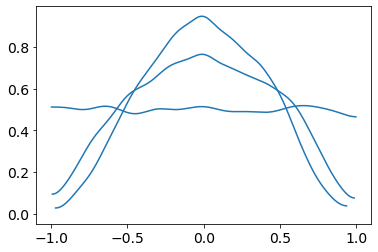

In [12]:
for i in range(3):
    az.plot_kde(dist.LKJ(2, i+1).sample(random.PRNGKey(44), (10000,))[:,0,1])

In [13]:
def model(cafe_id, afternoon, wait=None):

    alpha_loc = numpyro.sample('alpha_loc', dist.Normal(5,2))
    beta_loc = numpyro.sample('beta_loc', dist.Normal(-1,0.5))
    rho = numpyro.sample('rho', dist.LKJ(2, 2))
    sigma_alpha_beta = numpyro.sample('sigma_alpha_beta', dist.Exponential(1).expand([2]))
    cov = jnp.outer(sigma_alpha_beta, sigma_alpha_beta) * rho
    sigma = numpyro.sample('sigma', dist.Exponential(1))

    alpha_beta = numpyro.sample('alpha_beta', dist.MultivariateNormal(loc=jnp.array([alpha_loc,beta_loc]), covariance_matrix=cov).expand([n_cafes]))
    alpha, beta = alpha_beta[:,0], alpha_beta[:,1]

    mu = alpha[cafe_id] + beta[cafe_id]*afternoon
    result = numpyro.sample('result', dist.Normal(mu, sigma), obs=wait)


m14_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m14_1.run(random.PRNGKey(0), cafe_id=d_sim.cafe_id.values.astype(int), afternoon=d_sim.afternoon.values, wait=d_sim.wait.values)
m14_1.print_summary()

sample: 100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s, 15 steps of size 3.28e-01. acc. prob=0.87]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha_beta[0,0]      3.28      0.20      3.28      2.95      3.61    482.42      1.00
    alpha_beta[0,1]     -0.68      0.26     -0.68     -1.09     -0.26    484.10      1.00
    alpha_beta[1,0]      3.17      0.20      3.16      2.83      3.47    520.29      1.01
    alpha_beta[1,1]     -0.86      0.26     -0.86     -1.33     -0.47    477.55      1.00
    alpha_beta[2,0]      3.78      0.20      3.78      3.45      4.09    580.81      1.00
    alpha_beta[2,1]     -0.88      0.24     -0.89     -1.28     -0.50    642.74      1.00
    alpha_beta[3,0]      4.20      0.21      4.21      3.83      4.53    522.30      1.00
    alpha_beta[3,1]     -0.92      0.27     -0.92     -1.32     -0.51    660.96      1.00
    alpha_beta[4,0]      3.06      0.22      3.06      2.68      3.38    705.82      1.00
    alpha_beta[4,1]     -1.05      0.28     -1.05     -1.51     -0.60    714.90      1.00
    alpha

<AxesSubplot:>

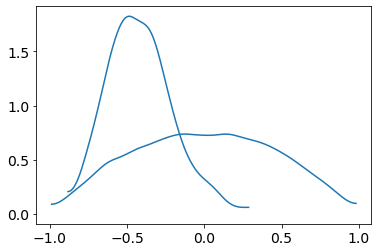

In [14]:
post = m14_1.get_samples()
az.plot_kde(post['rho'][:,0,1])
az.plot_kde(dist.LKJ(2, 2).sample(random.PRNGKey(0), (10000,))[:,0,1])

In [15]:
post['rho'][:,0,1]

DeviceArray([-7.69353509e-01, -3.78499866e-01, -7.83868074e-01,
             -4.53071356e-01, -3.19166273e-01, -2.73690939e-01,
             -4.18550558e-02, -4.73670870e-01, -5.25412619e-01,
             -4.72449780e-01, -3.74443144e-01, -3.95896763e-01,
             -5.31513751e-01, -8.08496952e-01, -4.18482929e-01,
             -5.42834342e-01, -6.85738623e-01, -4.71251428e-01,
             -6.76853895e-01, -5.54022551e-01, -5.42122424e-01,
             -4.67839271e-01, -3.77928793e-01, -3.21999639e-01,
              2.50380933e-02, -3.29243034e-01, -3.19042712e-01,
             -6.95818067e-01, -7.08498895e-01, -4.42325205e-01,
              1.73251498e-02, -1.53614983e-01, -4.63718116e-01,
             -1.76543951e-01, -3.39473009e-01, -4.03620720e-01,
             -2.23369449e-01, -7.38053083e-01, -2.79973745e-01,
             -7.66312718e-01, -7.11848259e-01, -5.74701846e-01,
             -3.07441831e-01, -9.95870531e-02, -6.53220594e-01,
             -4.12599802e-01, -2.8756120

In [16]:
# compute unpooled estimates directly from data
a_b_list = []
for cafe in range(n_cafes):
    idx = cafe_id==cafe
    x = is_afternoon[idx]
    y = wait[idx]
    A = np.vstack([x, np.ones(len(x))]).T
    b, a = np.linalg.lstsq(A, y, rcond=None)[0]
    a_b_list.append([a,b])
unpooled = np.array(a_b_list)

In [17]:
partpooled = post['alpha_beta'].mean(axis=0)

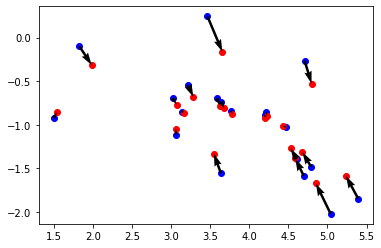

In [18]:
fig, ax = plt.subplots()
x1, y1 = unpooled[:,0], unpooled[:,1]
x2, y2 = partpooled[:,0], partpooled[:,1]
ax.scatter(x1, y1, c='b')
ax.scatter(x2, y2, c='r')
ax.quiver(x1, y1, (x2-x1), (y2-y1), angles='xy', scale_units='xy', scale=1)


In [19]:
d = pd.read_csv('data/chimpanzees.csv', sep=';')

In [20]:
d.sample(5)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
230,4,NaN,0,3,29,1,1,1
151,3,NaN,0,2,15,0,1,0
93,2,NaN,0,4,43,0,0,1
486,7,7.0,1,4,38,0,0,1
116,2,5.0,1,2,16,1,1,1


In [21]:
t = d.groupby(['prosoc_left', 'condition']).count().reset_index().reset_index()[['index', 'prosoc_left', 'condition']].rename(columns = {'index':'treatment'})
d = pd.merge(d, t)
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,0
1,1,NaN,0,1,4,0,0,1,0
2,1,NaN,0,1,8,0,1,0,0
3,1,NaN,0,2,18,0,1,0,0
4,1,NaN,0,2,20,0,1,0,0
...,...,...,...,...,...,...,...,...,...
499,7,6.0,1,5,58,1,1,1,3
500,7,7.0,1,5,60,1,1,1,3
501,7,5.0,1,6,62,1,1,1,3
502,7,4.0,1,6,64,1,1,1,3


In [22]:
num_actors = len(d.actor.unique())
num_blocks = len(d.block.unique())
num_treatments = len(d.treatment.unique())


def model(treatment, actor, block, pulled_left=None):

    rho_alpha = numpyro.sample('rho_alpha', dist.LKJ(num_treatments, 2))
    rho_beta = numpyro.sample('rho_beta', dist.LKJ(num_treatments, 2))

    sigma_actor = numpyro.sample('sigma_actor', dist.Exponential(1).expand([num_treatments,]))
    sigma_block = numpyro.sample('sigma_block', dist.Exponential(1).expand([num_treatments,]))

    cov_actor = jnp.outer(sigma_actor, sigma_actor) * rho_alpha
    cov_block = jnp.outer(sigma_block, sigma_block) * rho_beta

    alpha = numpyro.sample('alpha', dist.MultivariateNormal(loc=jnp.repeat(0,num_treatments), covariance_matrix=cov_actor).expand([num_actors]))
    beta = numpyro.sample('beta', dist.MultivariateNormal(loc=jnp.repeat(0,num_treatments), covariance_matrix=cov_block).expand([num_blocks]))

    gamma = numpyro.sample('gamma', dist.Normal(0,1.5).expand([num_treatments]))

    logit = gamma[treatment] + alpha[actor, treatment] + beta[block, treatment]
    result = numpyro.sample('result', dist.BernoulliLogits(logit), obs=pulled_left)


m14_2 = MCMC(NUTS(model), num_warmup=500, num_samples=2000)
m14_2.run(random.PRNGKey(0), treatment=d.treatment.values.astype(int), actor=d.actor.values.astype(int)-1, block=d.block.values-1, pulled_left=d.pulled_left.values)
m14_2.print_summary()


sample: 100%|██████████| 2500/2500 [00:41<00:00, 60.81it/s, 63 steps of size 6.66e-02. acc. prob=0.84]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha[0,0]     -0.90      0.68     -0.87     -2.04      0.16    569.01      1.00
    alpha[0,1]     -1.00      0.76     -0.99     -2.25      0.29    610.02      1.00
    alpha[0,2]     -0.54      0.50     -0.51     -1.44      0.23    971.33      1.00
    alpha[0,3]     -0.67      0.71     -0.64     -1.86      0.47    516.05      1.00
    alpha[1,0]      3.12      1.22      2.96      1.40      5.19    604.30      1.00
    alpha[1,1]      4.35      1.62      4.09      1.92      6.95    899.55      1.00
    alpha[1,2]      2.03      0.99      1.89      0.52      3.53    934.29      1.00
    alpha[1,3]      3.33      1.54      3.09      1.06      5.47    977.34      1.00
    alpha[2,0]     -1.16      0.68     -1.13     -2.26     -0.06    639.19      1.00
    alpha[2,1]     -1.59      0.81     -1.54     -2.93     -0.30    702.75      1.00
    alpha[2,2]     -0.35      0.50     -0.36     -1.18      0.45

In [23]:
num_actors = len(d.actor.unique())
num_blocks = len(d.block.unique())
num_treatments = len(d.treatment.unique())


def model(treatment, actor, block, pulled_left=None):

        sigma_actor = numpyro.sample("sigma_actor", dist.Exponential(1).expand([num_treatments]))
        z_actor = numpyro.sample("z_actor", dist.Normal(0, 1).expand([num_treatments, num_actors]))
        L_Rho_actor = numpyro.sample("L_Rho_actor", dist.LKJCholesky(num_treatments, 2))

        sigma_block = numpyro.sample("sigma_block", dist.Exponential(1).expand([num_treatments]))
        z_block = numpyro.sample("z_block", dist.Normal(0, 1).expand([num_treatments, num_blocks]))
        L_Rho_block = numpyro.sample("L_Rho_block", dist.LKJCholesky(num_treatments, 2))


        alpha = numpyro.deterministic(
            "alpha", ((jnp.diag(sigma_actor) @ L_Rho_actor) @ z_actor).T
        )
        beta = numpyro.deterministic(
            "beta", ((jnp.diag(sigma_block) @ L_Rho_block) @ z_block).T
        )

        gamma = numpyro.sample('gamma', dist.Normal(0,1.5).expand([num_treatments]))

        logit = gamma[treatment] + alpha[actor, treatment] + beta[block, treatment]
        result = numpyro.sample('result', dist.BernoulliLogits(logit), obs=pulled_left)

m14_3 = MCMC(NUTS(model), num_warmup=500, num_samples=2000)
m14_3.run(random.PRNGKey(0), treatment=d.treatment.values.astype(int), actor=d.actor.values.astype(int)-1, block=d.block.values-1, pulled_left=d.pulled_left.values)
m14_3.print_summary()



sample: 100%|██████████| 2500/2500 [00:27<00:00, 89.41it/s, 31 steps of size 1.70e-01. acc. prob=0.86] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
L_Rho_actor[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
L_Rho_actor[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_actor[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_actor[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_actor[1,0]      0.52      0.25      0.55      0.15      0.92   1590.54      1.00
L_Rho_actor[1,1]      0.80      0.16      0.83      0.58      1.00   1467.67      1.00
L_Rho_actor[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_actor[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_actor[2,0]      0.43      0.29      0.47      0.01      0.90   1905.10      1.00
L_Rho_actor[2,1]      0.29      0.33      0.31     -0.17      0.86   1615.66      1.00
L_Rho_actor[2,2]      0.71      0.17      

In [24]:
params = ['alpha', 'beta', 'gamma']
post_nc = m14_3.get_samples(group_by_chain=False)
post_nc = { k: post_nc[k] for k in params }
samples_nc = tree_map(lambda x: x[None, ...], post_nc) # ess function assumes first dim is chain num, so add a leading dim for that

post_c = m14_2.get_samples(group_by_chain=False)
post_c = { k: post_c[k] for k in params }
samples_c = tree_map(lambda x: x[None, ...], post_c) # ess function assumes first dim is chain num, so add a leading dim for that


In [25]:
res = {}
for p in params:
    res[p] = {
        'centered':effective_sample_size(np.array(samples_c[p])),
        'non-centered':effective_sample_size(np.array(samples_nc[p]))
    }

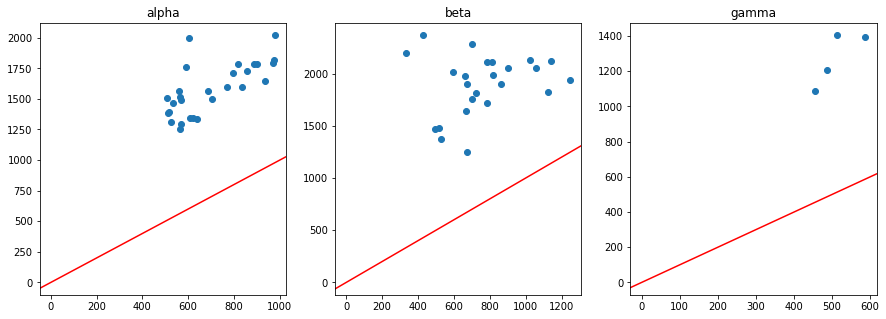

In [26]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, p in enumerate(params):
    axes[i].scatter(x=res[p]['centered'], y=res[p]['non-centered'])
    axes[i].set_title(str(p))
    axes[i].axline((0, 0), (1, 1), color='r')

### Aside to check how to get a target covariance matrix from standard normal variables using Cholesky factor

In [27]:
# uncorrelated standard normal variables
num_vars = 3
X = np.random.standard_normal((num_vars,1000000))

# target correlation (for all pairs of variables)
corr = 0.8

# target correlation matrix
rho = np.full((num_vars, num_vars), corr)
np.fill_diagonal(rho, 1)

# target standard deviations...
std = np.arange(start=2, stop = 2+num_vars)
# ...meaning that we expect to get a covariance matrix like
print('Target covariance matrix: ', np.outer(std, std) * rho)

# lower Cholesky factor
L = np.linalg.cholesky(rho)

# scale to get target standard deviations
l = np.diag(std) @ L

# generated correlated, scaled variable
Y = l @ X

# check we get target correlation and covariance
print('covariance of Y: ', np.cov(Y))
print('correlation of Y: ', np.corrcoef(Y))


Target covariance matrix:  [[ 4.   4.8  6.4]
 [ 4.8  9.   9.6]
 [ 6.4  9.6 16. ]]
covariance of Y:  [[ 4.00376954  4.80039857  6.40227644]
 [ 4.80039857  9.00043912  9.5933444 ]
 [ 6.40227644  9.5933444  15.98963077]]
correlation of Y:  [[1.         0.7996702  0.80016706]
 [0.7996702  1.         0.79968503]
 [0.80016706 0.79968503 1.        ]]


In [28]:
n = 500
init_key = random.PRNGKey(0)
keys = random.split(init_key, 4)

U_sim = random.normal(keys[0], (n,))
Q_sim = random.choice(keys[1], 4, (n,), replace=True)
E_sim = U_sim + Q_sim + random.normal(keys[2], (n,))
W_sim = U_sim + 0*E_sim + random.normal(keys[3], (n,))


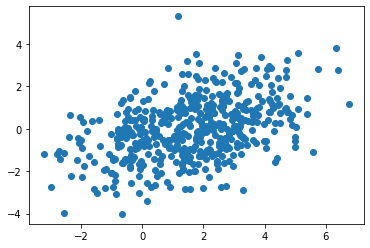

In [29]:
plt.scatter(E_sim, W_sim)

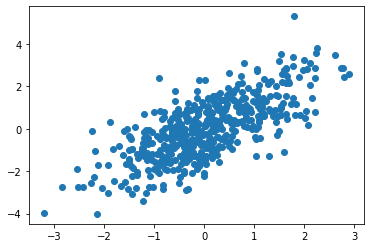

In [30]:
plt.scatter(U_sim, W_sim)

In [34]:
def model(E, W=None):
    a = numpyro.sample('a', dist.Normal(0,1.5))
    b_e = numpyro.sample('b', dist.Normal(1, 1.5))
    mu = numpyro.deterministic('mu', a + b_e*E)
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    result = numpyro.sample('wages', dist.Normal(mu, sigma), obs=W)

m14_4 = MCMC(NUTS(model), num_warmup=500, num_samples=2000)
m14_4.run(random.PRNGKey(0), E=E_sim, W=W_sim)
m14_4.print_summary()

sample: 100%|██████████| 2500/2500 [00:04<00:00, 517.83it/s, 7 steps of size 6.23e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.51      0.08     -0.51     -0.63     -0.39   1225.09      1.00
         b      0.33      0.03      0.33      0.28      0.38   1244.39      1.00
     sigma      1.29      0.04      1.28      1.22      1.35   1302.01      1.00

Number of divergences: 0


In [35]:
def model(E, Q, W=None):
    a = numpyro.sample('a', dist.Normal(0,1.5))
    b_e = numpyro.sample('b_e', dist.Normal(1, 1.5))
    b_q = numpyro.sample('b_q', dist.Normal(0, 1.5))
    mu = numpyro.deterministic('mu', a + b_e*E +b_q*Q)
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    result = numpyro.sample('wages', dist.Normal(mu, sigma), obs=W)

m14_5 = MCMC(NUTS(model), num_warmup=500, num_samples=2000)
m14_5.run(random.PRNGKey(0), E=E_sim, Q=Q_sim, W=W_sim)
m14_5.print_summary()

sample: 100%|██████████| 2500/2500 [00:04<00:00, 526.03it/s, 15 steps of size 3.12e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.03      0.09      0.03     -0.12      0.17   1028.93      1.00
       b_e      0.54      0.04      0.54      0.49      0.60   1280.26      1.00
       b_q     -0.56      0.06     -0.56     -0.65     -0.46   1008.36      1.00
     sigma      1.20      0.04      1.20      1.14      1.26   1217.99      1.00

Number of divergences: 0


In [42]:
def model(E, Q, W=None):
    a_W = numpyro.sample('a_W', dist.Normal(0,2))
    a_E = numpyro.sample('a_E', dist.Normal(0,2))
    b_WE = numpyro.sample('b_WE', dist.Normal(0, 1))
    #b_WU = numpyro.sample('b_WU', dist.Normal(0, 1.5))
    #b_EU = numpyro.sample('b_EU', dist.Normal(0, 1.5))
    b_EQ = numpyro.sample('b_EQ', dist.Normal(0, 1))    

    mu_W = numpyro.deterministic('mu_W', a_W + b_WE*E)
    mu_E = numpyro.deterministic('mu_E', a_E + b_EQ*Q)
    
    sigma = numpyro.sample('sigma', dist.Exponential(1).expand([2,]))
    rho = numpyro.sample('rho', dist.LKJ(2, 2))
    cov = jnp.outer(sigma, sigma) * rho

    W_E = numpyro.sample('W_E', dist.MultivariateNormal(jnp.stack([mu_W, mu_E], -1), covariance_matrix=cov), jnp.stack([W, E], -1))


m14_6 = MCMC(NUTS(model), num_warmup=500, num_samples=2000)
m14_6.run(random.PRNGKey(0), E=E_sim, Q=Q_sim, W=W_sim)
m14_6.print_summary()

sample: 100%|██████████| 2500/2500 [00:11<00:00, 214.40it/s, 7 steps of size 2.98e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_E     -0.09      0.11     -0.09     -0.28      0.08    876.60      1.00
       a_W     -0.03      0.10     -0.03     -0.20      0.14    871.13      1.00
      b_EQ      1.07      0.06      1.07      0.98      1.17    917.43      1.00
      b_WE      0.03      0.05      0.03     -0.05      0.12    759.41      1.00
  rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  rho[0,1]      0.51      0.05      0.52      0.43      0.59    831.94      1.00
  rho[1,0]      0.51      0.05      0.52      0.43      0.59    831.94      1.00
  rho[1,1]      1.00      0.00      1.00      1.00      1.00    228.73      1.00
  sigma[0]      1.40      0.06      1.40      1.31      1.50    887.75      1.00
  sigma[1]      1.41      0.04      1.41      1.34      1.48   1641.55      1.00

Number of divergences: 0


In [43]:
!curl -o data/KosterLeckie.csv  https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/KosterLeckie.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12415  100 12415    0     0  23380      0 --:--:-- --:--:-- --:--:-- 23380


In [44]:
d = pd.read_csv('data/KosterLeckie.csv')

In [45]:
d.sample(5)

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
70,4,6,71,19,4,-0.022,1,0,0,0,-2.099,0.093,0
57,3,14,58,12,2,-0.014,0,1,0,0,-2.798,0.113,0
7,1,9,8,0,1,0.000,0,0,0,1,-1.644,0.003,0
293,21,25,294,9,1,-0.696,0,0,1,0,-1.895,0.043,0
241,14,22,242,0,1,-0.011,0,0,0,1,-3.224,0.008,0


In [47]:
d.describe()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,8.666667,17.333333,150.500000,3.866667,5.703333,-0.126360,0.063333,0.120000,0.213333,0.256667,-2.258487,0.041687,0.003333
std,5.773503,5.773503,86.746758,7.966625,11.466484,0.213482,0.243968,0.325504,0.410346,0.437524,0.593512,0.076389,0.057735
min,1.000000,2.000000,1.000000,0.000000,0.000000,-1.236000,0.000000,0.000000,0.000000,0.000000,-4.068000,0.000000,0.000000
25%,4.000000,13.000000,75.750000,0.000000,1.000000,-0.108500,0.000000,0.000000,0.000000,0.000000,-2.583500,0.000000,0.000000
50%,8.000000,18.000000,150.500000,1.000000,2.000000,-0.022000,0.000000,0.000000,0.000000,0.000000,-2.178000,0.015000,0.000000
75%,13.000000,22.000000,225.250000,4.000000,6.000000,-0.011000,0.000000,0.000000,0.000000,1.000000,-1.846000,0.046000,0.000000
max,24.000000,25.000000,300.000000,75.000000,110.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.031000,0.552000,1.000000


In [48]:
d.did.is_unique

True

<AxesSubplot:xlabel='giftsAB', ylabel='giftsBA'>

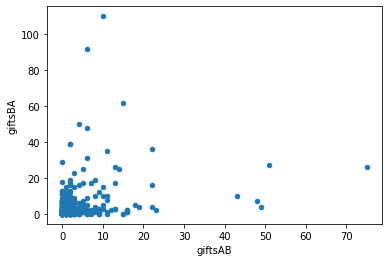

In [49]:
d.plot.scatter('giftsAB', 'giftsBA')

In [51]:
d[['giftsAB', 'giftsBA']].corr()

,giftsAB,giftsBA
giftsAB,1.000000,0.239155
giftsBA,0.239155,1.000000


In [72]:
num_households = len(pd.concat((d['hidA'], d['hidB'])).unique())
num_dyads = d['did'].nunique()

def model(a, b, did, g_ab=None, g_ba=None):

    alpha = numpyro.sample('alpha', dist.Normal(0,1))

    # Household effects.  Each household has a level of giving and a level of recieving.  Across the population of households, propensity to give and receive may be correlated.
    sigma_g = numpyro.sample('sigma_g', dist.Exponential(1))
    sigma_r = numpyro.sample('sigma_r', dist.Exponential(1))
    rho_h = numpyro.sample('rho_household', dist.LKJCholesky(2,2))
    cov_h = jnp.outer(sigma_g, sigma_r) * rho_h
    g_r = numpyro.sample('g_r', dist.MultivariateNormal(loc=0, covariance_matrix=cov_h).expand([num_households]))
    g, r = g_r[:,0], g_r[:,1]

    # Dyad effects.  Each dyad has its own level of giving from A to B and giving from B to A.  Across the population of dyads, the 'generosity' of A and the generosity of 'B' may be correlated.
    sigma_ab = numpyro.sample('sigma_ab', dist.Exponential(1))
    sigma_ba = numpyro.sample('sigma_ba', dist.Exponential(1))
    rho_d = numpyro.sample('rho_dyad', dist.LKJCholesky(2,2))
    cov_d = jnp.outer(sigma_ab, sigma_ba) * rho_d
    d = numpyro.sample('d', dist.MultivariateNormal(loc=0, covariance_matrix=cov_d).expand([num_dyads]))

    # Regression models for gifts
    l_ab = jnp.exp( alpha + g[a] + r[b] + d[did, 0] )
    l_ba = jnp.exp( alpha + g[b] + r[a] + d[did, 1] )

    numpyro.sample('gift_a_b', dist.Poisson(l_ab), obs=g_ab)
    numpyro.sample('gift_b_a', dist.Poisson(l_ba), obs=g_ba)

    numpyro.deterministic('household_corr', rho_h @ rho_h.T)
    numpyro.deterministic('dyad_corr', rho_d @ rho_d.T)


m14_7 = MCMC(NUTS(model), num_warmup=500, num_samples=2000)
m14_7.run(random.PRNGKey(0), a=d.hidA.values-1, b=d.hidB.values-1, did=d.did.values-1, g_ab=d.giftsAB.values, g_ba=d.giftsBA.values)
m14_7.print_summary()

sample: 100%|██████████| 2500/2500 [00:54<00:00, 45.57it/s, 63 steps of size 7.07e-02. acc. prob=0.92] 



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha      0.54      0.16      0.55      0.29      0.81    546.73      1.00
            d[0,0]     -0.57      0.89     -0.52     -2.02      0.83   2437.22      1.00
            d[0,1]      0.18      0.53      0.20     -0.69      1.02   1886.53      1.00
            d[1,0]      2.14      0.53      2.16      1.33      3.03   1342.97      1.00
            d[1,1]      1.55      0.35      1.55      0.98      2.13    652.83      1.00
            d[2,0]      0.45      0.65      0.47     -0.58      1.56   1767.77      1.00
            d[2,1]      1.04      0.53      1.04      0.13      1.84   1887.31      1.00
            d[3,0]      0.73      0.60      0.75     -0.24      1.73   1584.16      1.00
            d[3,1]      0.17      0.56      0.19     -0.76      1.10   1933.26      1.00
            d[4,0]      1.43      0.50      1.45      0.65      2.28   1130.60      1.00
            d[4,1]  

In [73]:
post = m14_7.get_samples()
post.keys()

dict_keys(['alpha', 'd', 'dyad_corr', 'g_r', 'household_corr', 'rho_dyad', 'rho_household', 'sigma_ab', 'sigma_ba', 'sigma_g', 'sigma_r'])

In [74]:
post['dyad_corr'].mean(axis=0)

DeviceArray([[1.        , 0.86531365],
             [0.86531365, 1.        ]], dtype=float32)

In [75]:
post['household_corr'].mean(axis=0)


DeviceArray([[ 1.       , -0.6718084],
             [-0.6718084,  1.       ]], dtype=float32)

In [84]:
give = jnp.exp( post['alpha'].reshape(-1,1) + post['g_r'][:,:,0] ).mean(axis=0)
receive = jnp.exp( post['alpha'].reshape(-1,1) + post['g_r'][:,:,1] ).mean(axis=0)

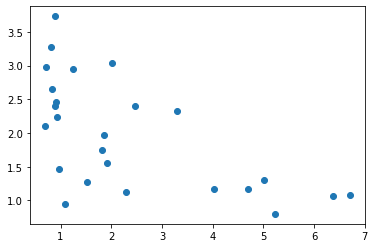

In [85]:
plt.scatter(give, receive)

In [86]:
!curl -o data/islandsDistMatrix.csv  https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/islandsDistMatrix.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   747  100   747    0     0   1380      0 --:--:-- --:--:-- --:--:--  1388


In [3]:
idm = pd.read_csv('data/islandsDistMatrix.csv', index_col=0)

In [4]:
idm

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000


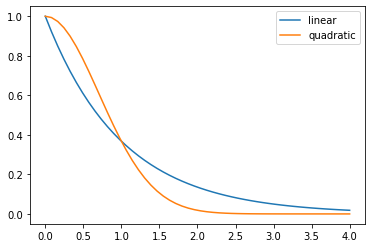

In [5]:
d = jnp.linspace(0,4)
fig, ax = plt.subplots()
ax.plot(d, jnp.exp(-1 * d), label='linear')
ax.plot(d, jnp.exp(-1 * d**2), label='quadratic')
ax.legend()

In [6]:
kline = pd.read_csv('data/Kline.csv', sep=';')
kline = kline.reset_index().rename(columns={'index':'society'})

In [7]:
kline

,society,culture,population,contact,total_tools,mean_TU
0,0,Malekula,1100,low,13,3.2
1,1,Tikopia,1500,low,22,4.7
2,2,Santa Cruz,3600,low,24,4.0
3,3,Yap,4791,high,43,5.0
4,4,Lau Fiji,7400,high,33,5.0
5,5,Trobriand,8000,high,19,4.0
6,6,Chuuk,9200,high,40,3.8
7,7,Manus,13000,low,28,6.6
8,8,Tonga,17500,high,55,5.4
9,9,Hawaii,275000,low,71,6.6


In [12]:
num_soc = len(kline)

def make_cov(idm, etasq, rhosq, sigmasq):
    d2 = jnp.square(idm)
    return etasq * jnp.exp(-1*rhosq*d2) + jnp.eye(idm.shape[0]) * sigmasq

def model(idm, p, s, t=None):

    # Get intercept for each society, such that sociaties that are closer have more similar intercepts
    etasq = numpyro.sample('eta_squared', dist.Exponential(2))
    rhosq = numpyro.sample('rho_squared', dist.Exponential(0.5))
    sigmasq = 0.01
    cov = make_cov(idm, etasq, rhosq, sigmasq)
    k = numpyro.sample('k', dist.MultivariateNormal(loc=0, covariance_matrix=cov))

    # Scientific model
    a, b, g = numpyro.sample('a_b_c', dist.Exponential(1).expand([3]))
    l = a * p**b  * jnp.exp(k[s]) / g
    result = numpyro.sample('num_tools', dist.Poisson(l), obs = t)

m14_8 = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
m14_8.run(random.PRNGKey(0), idm=idm.values, p=kline.population.values, s=kline.society.values, t=kline.total_tools.values)
m14_8.print_summary()

sample: 100%|██████████| 1500/1500 [00:05<00:00, 261.71it/s, 63 steps of size 3.06e-02. acc. prob=0.95] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     a_b_c[0]      1.35      1.08      1.02      0.09      2.81    640.34      1.00
     a_b_c[1]      0.28      0.09      0.28      0.14      0.42    231.28      1.01
     a_b_c[2]      0.60      0.58      0.42      0.02      1.36    325.15      1.01
  eta_squared      0.20      0.20      0.14      0.00      0.43    252.64      1.00
         k[0]     -0.14      0.30     -0.15     -0.67      0.33    121.80      1.03
         k[1]      0.01      0.30     -0.01     -0.44      0.55    112.85      1.03
         k[2]     -0.04      0.29     -0.04     -0.53      0.36    126.51      1.02
         k[3]      0.37      0.26      0.37     -0.08      0.77    120.35      1.04
         k[4]      0.10      0.24      0.08     -0.26      0.49    133.52      1.04
         k[5]     -0.37      0.25     -0.36     -0.78      0.02    174.21      1.03
         k[6]      0.15      0.25      0.14     -0.26      0.54    135.66  

In [13]:
# Non-centreed versionm

num_soc = len(kline)

def make_cholesky(idm, etasq, rhosq, sigmasq):
    d2 = jnp.square(idm)
    k = etasq * jnp.exp(-1*rhosq*d2) + jnp.eye(idm.shape[0]) * sigmasq
    return jnp.linalg.cholesky(k)


def model(idm, p, s, t=None):

    # Get intercept for each society, such that sociaties that are closer have more similar intercepts
    etasq = numpyro.sample('eta_squared', dist.Exponential(2))
    rhosq = numpyro.sample('rho_squared', dist.Exponential(0.5))
    sigmasq = 0.01
    l = make_cholesky(idm, etasq, rhosq, sigmasq)
    k_norm = numpyro.sample("k_norm", dist.Normal(0, 1).expand([num_soc]))
    k = numpyro.deterministic('k', l @ k_norm)

    # Scientific model
    a, b, g = numpyro.sample('a_b_c', dist.Exponential(1).expand([3]))
    l = a * p**b  * jnp.exp(k[s]) / g
    result = numpyro.sample('num_tools', dist.Poisson(l), obs = t)

m14_8_nc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
m14_8_nc.run(random.PRNGKey(0), idm=idm.values, p=kline.population.values, s=kline.society.values, t=kline.total_tools.values)
m14_8_nc.print_summary()

sample: 100%|██████████| 1500/1500 [00:05<00:00, 291.61it/s, 127 steps of size 2.98e-02. acc. prob=0.94] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     a_b_c[0]      1.39      1.02      1.15      0.09      2.75   1127.09      1.00
     a_b_c[1]      0.27      0.08      0.27      0.15      0.41    339.66      1.00
     a_b_c[2]      0.58      0.54      0.42      0.02      1.24    750.65      1.00
  eta_squared      0.19      0.22      0.13      0.00      0.40    300.25      1.00
    k_norm[0]     -0.44      0.75     -0.42     -1.74      0.68    540.37      1.00
    k_norm[1]      0.36      0.79      0.34     -0.88      1.57   1085.01      1.00
    k_norm[2]     -0.21      0.78     -0.23     -1.40      1.06    982.33      1.00
    k_norm[3]      0.93      0.62      0.90      0.00      1.95    613.61      1.01
    k_norm[4]      0.39      0.66      0.37     -0.67      1.46    538.99      1.00
    k_norm[5]     -1.05      0.66     -1.05     -2.15     -0.05    650.91      1.00
    k_norm[6]      0.35      0.60      0.31     -0.51      1.37    610.28  

In [24]:
az14_8_nc = az.from_numpyro(m14_8_nc)
az.summary(az14_8_nc)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_b_c[0],1.388,1.021,0.080,3.235,0.030,0.022,895.0,563.0,NaN
a_b_c[1],0.275,0.084,0.123,0.440,0.005,0.003,342.0,298.0,NaN
a_b_c[2],0.579,0.541,0.020,1.541,0.019,0.014,490.0,538.0,NaN
eta_squared,0.195,0.216,0.002,0.526,0.012,0.009,274.0,448.0,NaN
k[0],-0.161,0.305,-0.726,0.422,0.013,0.010,529.0,545.0,NaN
k[1],-0.029,0.295,-0.536,0.571,0.013,0.009,533.0,448.0,NaN
k[2],-0.075,0.283,-0.564,0.509,0.012,0.009,530.0,491.0,NaN
k[3],0.338,0.255,-0.136,0.827,0.010,0.007,636.0,600.0,NaN
k[4],0.075,0.242,-0.441,0.499,0.009,0.009,736.0,633.0,NaN
k[5],-0.378,0.262,-0.853,0.089,0.010,0.007,638.0,710.0,NaN


In [25]:
!curl -o data/Primates301.csv  https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Primates301.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28965  100 28965    0     0  67675      0 --:--:-- --:--:-- --:--:-- 68152


In [26]:
!curl -o data/Primates301_distance_matrix.csv  https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Primates301_distance_matrix.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  925k  100  925k    0     0  2303k      0 --:--:-- --:--:-- --:--:-- 2309k


In [27]:
!curl -o data/Primates301_vcov_matrix.csv  https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Primates301_vcov_matrix.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  583k  100  583k    0     0  1265k      0 --:--:-- --:--:-- --:--:-- 1268k


In [30]:
!curl -o data/Primates301.newick  https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Primates301.newick

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11999  100 11999    0     0  33238      0 --:--:-- --:--:-- --:--:-- 33330


In [3]:
# from ete3 import Tree, TreeStyle
# Couldn't get ete tree plottngto work :-(

In [3]:
d = pd.read_csv('data/Primates301.csv', sep=';')


In [7]:
d.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,301,301,Allenopithecus_nigroviridis,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genus,301,68,Macaca,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
species,301,258,fulvus,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subspecies,34,34,boliviensis,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spp_id,301.0,NaN,NaN,NaN,151.0,87.035433,1.0,76.0,151.0,226.0,301.0
genus_id,301.0,NaN,NaN,NaN,34.186047,18.611429,1.0,17.0,36.0,48.0,68.0
social_learning,203.0,NaN,NaN,NaN,2.300493,16.513821,0.0,0.0,0.0,0.0,214.0
research_effort,186.0,NaN,NaN,NaN,38.763441,80.588967,1.0,6.0,16.0,37.75,755.0
brain,184.0,NaN,NaN,NaN,68.493207,82.841544,1.63,11.825,58.55,86.1975,491.27
body,238.0,NaN,NaN,NaN,6795.184328,14229.825627,31.23,739.4425,3553.5,7465.0,130000.0


In [10]:
dd = d.dropna(subset=['brain', 'body', 'group_size'])
dd.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,151,151,Allenopithecus_nigroviridis,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genus,151,59,Cercopithecus,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
species,151,141,edwardsi,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subspecies,7,7,atys,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spp_id,151.0,NaN,NaN,NaN,150.562914,89.121832,1.0,75.5,141.0,231.0,301.0
genus_id,151.0,NaN,NaN,NaN,34.278146,19.152079,1.0,17.0,35.0,49.0,68.0
social_learning,143.0,NaN,NaN,NaN,3.181818,19.622004,0.0,0.0,0.0,0.0,214.0
research_effort,140.0,NaN,NaN,NaN,46.621429,91.035645,1.0,8.0,18.0,43.5,755.0
brain,151.0,NaN,NaN,NaN,63.363311,69.346113,1.63,11.465,57.86,86.56,490.41
body,151.0,NaN,NaN,NaN,6575.549669,12263.573744,43.0,800.0,4450.0,7492.5,120950.0


In [14]:
scaler = StandardScaler()
b_m_g = scaler.fit_transform(np.log(dd[['brain', 'body', 'group_size']]))


In [17]:
def model(g, m, b=None):

    num_species = g.shape[0]

    a = numpyro.sample('a', dist.Normal(0,1.5))
    b_g = numpyro.sample('b_g', dist.Normal(0,1.5))
    b_m = numpyro.sample('b_m', dist.Normal(0,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + b_g * g + b_m * m

    result = numpyro.sample('log_brain', dist.MultivariateNormal(mu, jnp.eye(num_species)*sigma**2), obs=b)

m14_9 = MCMC(NUTS(model), num_warmup=500, num_samples=1000)
m14_9.run(random.PRNGKey(0), g=b_m_g[:,2], m=b_m_g[:,1], b=b_m_g[:,0])
m14_9.print_summary()

sample: 100%|██████████| 1500/1500 [01:03<00:00, 23.56it/s, 3 steps of size 6.13e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.02      0.00     -0.03      0.03    964.45      1.00
       b_g      0.12      0.02      0.12      0.08      0.16    837.90      1.00
       b_m      0.90      0.02      0.90      0.86      0.93    831.00      1.00
     sigma      0.22      0.01      0.22      0.20      0.24    902.07      1.00

Number of divergences: 0
